## Linear denoiser

What's new:

* Enforcing toeplitz matrix
* Running denoiser for 7 channels
* Limiting max PTP for data covariance estimation

Next:

* Test FPR before/after
* TEst TPR before/after

In [64]:
USE_TOEPLITZ = True
CHANNELS = [0, 1, 2, 3, 4, 5, 6]
MAX_PTP_FOR_COVARIANCE_ESTIMATION = 40
SAVE_RESULTS = True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
from collections import defaultdict

from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from sklearn import metrics

from yass.augment import make
from pathlib import Path
from statsmodels.tsa.stattools import acf
import sklearn_evaluation.plot as skplot

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.templates import util as templates_utl
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate
from yass.augment import util as augment_util
from yass.augment import noise as noise_utils
from yass.batch import RecordingsReader
from yass.augment.util import amplitudes
from yass.detect import nnet, nnet_experimental
from yass import preprocess

import seaborn as sns
import pandas as pd
from dstools import plot
from keras.models import load_model
import seaborn as sns

Using TensorFlow backend.


In [4]:
plt.rcParams['figure.figsize'] = (10, 10)

In [5]:
from os import path

path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

path_to_detector = '/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/detect_nn2.ckpt'

In [6]:
yass.set_config("../config/gcloud/49/default.yaml", 'noisy')
CONFIG = read_config()

In [7]:
from yass.geometry import make_channel_index

ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)

rec_all = RecordingsReader(path_to_standarized, loader='array').data

# (spatial_sig,
#  temporal_sig) = noise_utils.noise_cov(rec, 61, 61)

rec_all.shape

(6000000, 49)

In [8]:
detector = NeuralNetDetector.load(path_to_detector, 0.5, ch_idx)

(standarized_path,
 standarized_params,
 whiten_filter) = (preprocess
                   .run(if_file_exists='skip'))

(index_clean_arr,
 index_all_arr) = nnet.run(standarized_path, standarized_params, whiten_filter,
                       'overwrite', False,
                        path_to_detector,
                        autoencoder='/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/ae_nn2.ckpt')

100%|██████████| 4595/4595 [00:37<00:00, 122.26it/s]
/home/Edu/yass/src/yass/neuralnetwork/model.py:110: UserWarning: Input waveform length (51) is larger than Network's (31) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only (31) middle observations for predition
  self.waveform_length))
/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


In [9]:
# FIXME: remove duplicated logic
def read_waveforms(rec, idxs, waveform_length, random_shift=False, add_offset=False):    
    """Read waveforms from rec using an array of spike times
    """
    n_obs, n_channels = rec.shape

    out = np.empty((len(idxs), waveform_length, n_channels))
    valid_idx = np.ones(len(idxs))

    half = int((waveform_length - 1)/2)

    for i, idx in enumerate(idxs):
        if add_offset:
            offset = -20
        else:
            offset = 0
    
        if random_shift:
            offset += np.random.randint(-20, 20)
    
        s = slice(idx - half + offset, idx + half + 1 + offset)

        if s.start >= 0 and s.stop <= n_obs:
            out[i] = rec[s]
        else:
            valid_idx[i] = 0
            print('invalid idx')

    return out[valid_idx.astype(bool)]


class SpikeIndex:
    
    def __init__(self, spike_index_array, channel_index=None, geometry=None,
                 neighbors=None):
        self.arr = spike_index_array
        self.channel_index = channel_index
        self.geometry = geometry
        self.neighbors = neighbors
    
    def get_times_from_channel(self, channel):
        return self.arr[self.arr[:, 1] == channel][:, 0]
    
    @property
    def shape(self):
        return self.arr.shape
    
    @property
    def n_unique_channels(self):
        return len(np.unique(self.arr[:, 1]))
    
    def read_waveforms_from_channel(self, rec, channel, waveform_length=51, random_shift=True,
                                    only_neighbors=True, add_offset=False):
        """Read waveforms from rec using an array of spike times
        """
        _, n_channels = rec.shape
    
        idxs = self.get_times_from_channel(channel)
    
        out = np.empty((len(idxs), waveform_length, n_channels))
        half = int((waveform_length - 1)/2)
    
        for i, idx in enumerate(idxs):
            if add_offset:
                offset = -20
            else:
                offset = 0
        
            if random_shift:
                offset += np.random.randint(-20, 20)

            out[i] = rec[idx-half + offset:idx+half+1 + offset]
        
        if only_neighbors:
            tp = TemplatesProcessor(out)
            out = tp.crop_spatially(self.neighbors, self.geometry, inplace=False).values

        return out

index_all = SpikeIndex(index_all_arr, ch_idx, CONFIG.geom, CONFIG.neigh_channels)
index_clean = SpikeIndex(index_clean_arr, ch_idx, CONFIG.geom, CONFIG.neigh_channels)

In [10]:
index_all.shape, index_all.n_unique_channels, index_clean.shape, index_clean.n_unique_channels

((716851, 2), 49, (80022, 2), 49)

In [11]:
def kill_signal_from_index(recordings, spike_index, window_size):
    """
    """
    recordings = np.copy(recordings)

    T, C = recordings.shape
    R = int((window_size-1)/2)

    # this will hold a flag 1 (noise), 0 (signal) for every obseration in the
    # recordings
    is_noise_idx = np.zeros((T, C))

    # go through every neighboring channel
    for c in range(C):

        # get indexes whose main channel is c
        idx_temp = spike_index[spike_index[:, 1] == c]

        # shift every index found
        for j in range(-R, R+1):

            # shift
            idx_temp2 = idx_temp + j

            # remove indexes outside range [0, T]
            idx_temp2 = idx_temp2[np.logical_and(idx_temp2 >= 0,
                                                 idx_temp2 < T)]

            # set surviving indexes to nan
            recordings[idx_temp2, c] = np.nan

        is_signal_idx_temp = np.isnan(recordings[:, c])

        # standarize data, ignoring nans
#         recordings[:, c] = recordings[:, c]/np.nanstd(recordings[:, c])

        # set non noise indexes to 0 in the recordings
        recordings[is_signal_idx_temp, c] = 0

        # save noise indexes
        is_noise_idx[~is_signal_idx_temp, c] = 1

    return recordings, is_noise_idx

In [12]:
rec_with_nas, is_noise_idx = kill_signal_from_index(rec_all, index_all.arr, 61)

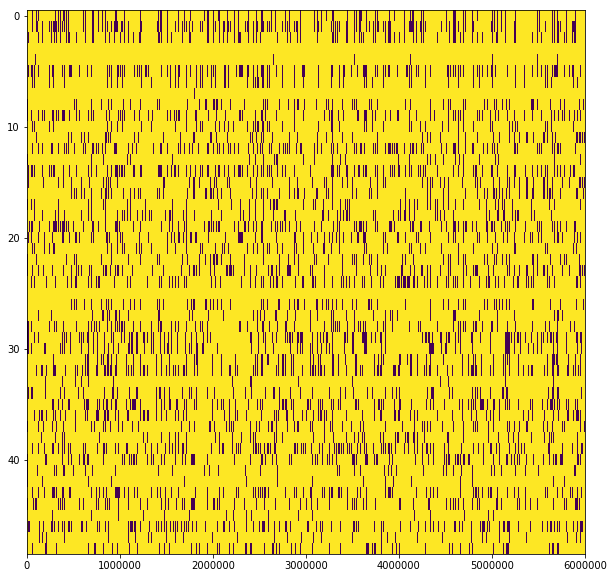

In [13]:
plt.imshow(is_noise_idx.T, aspect='auto')

In [14]:
noise_samples = noise_utils.search_noise_snippets(rec_with_nas, is_noise_idx, sample_size=20000,
                                          temporal_size=51, channel_choices=CONFIG.channel_index[[0], :7],
                                          max_trials_per_sample=1000,
                                          allow_smaller_sample_size=False)
noise_samples.shape

(20000, 51, 7)

In [15]:
def sample(rec, waveform_length, n):
    """Sample n waveforms of length waveform_length from recordings
    """
    min_idx = 0
    max_idx = rec.shape[0] - waveform_length

    idxs = np.random.randint(min_idx, max_idx, n)

    samples = np.empty((n, waveform_length, rec.shape[1]))

    for i, idx in enumerate(idxs):
        samples[i] = rec[i:i+waveform_length, :]
    
    return samples


def sample_noise(rec, waveform_length, n, detector, max_amplitude):
    """
    Sample n noise snippets of length waveform_length from recordings, pass them through a detector
    and remove the ones with > amplitude than max_amplitude
    """
    noise = np.empty((n, waveform_length, rec.shape[1]))
    remaining = n
    
    while remaining > 0:
        wfs = sample(rec, waveform_length, n)

        noise_detector_idx = ~ detector.predict(wfs).astype(bool)
        noise_amplitude_idx = augment_util.amplitudes(wfs) <= max_amplitude
        noise_idx = noise_detector_idx & noise_amplitude_idx

        noise_found = noise_idx.sum()

        idx_start = n - remaining
        idx_end = idx_start + noise_found
                
        if idx_end > n:
            idx_end = n

        noise[idx_start:idx_end] = wfs[noise_idx][:idx_end-idx_start, :]
        
        remaining -= noise_found
    
    return noise

In [16]:
# get noise samples from first channel neighbors,
# TODO: compute noise covariance per channel + neighbors
rec = rec_all[:, ch_idx[0]]
noise_samples = sample_noise(rec, 51, 20000, detector, 4)

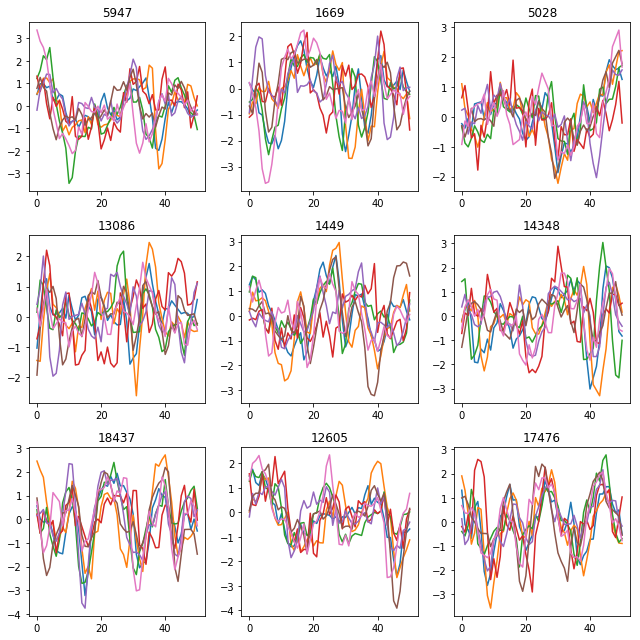

In [17]:
plot.grid_from_array(noise_samples, axis=0, elements=9, auto_figsize=3)

In [18]:
from sklearn.covariance import EmpiricalCovariance, LedoitWolf

## Compute the noise sample covariance using the noise snippets

In [19]:
noise_cov = (LedoitWolf(store_precision=False, assume_centered=False)
             .fit(noise_samples.reshape(noise_samples.shape[0], -1))).covariance_

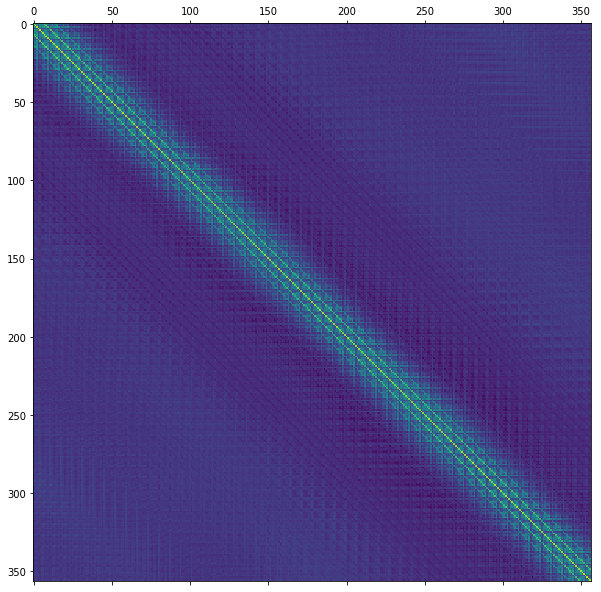

In [20]:
plt.matshow(noise_cov)

In [21]:
if isinstance(CHANNELS, list):
    spikes_all_dict = defaultdict(lambda: None)
    for channel in CHANNELS:
        print(f'Getting spikes from channel {channel}...')
        spikes_all_dict[channel] = index_all.read_waveforms_from_channel(rec_all, channel=channel, random_shift=False,
                                                                         only_neighbors=True)
    
    spikes_all = np.concatenate([s for s in spikes_all_dict.values()], axis=0)
else:
    spikes_all = index_all.read_waveforms_from_channel(rec_all, channel=CHANNEL, random_shift=False,
                                               only_neighbors=True)

Getting spikes from channel 0...
Getting spikes from channel 1...
Getting spikes from channel 2...
Getting spikes from channel 3...
Getting spikes from channel 4...
Getting spikes from channel 5...
Getting spikes from channel 6...


In [22]:
spikes_all.shape

(108520, 51, 7)

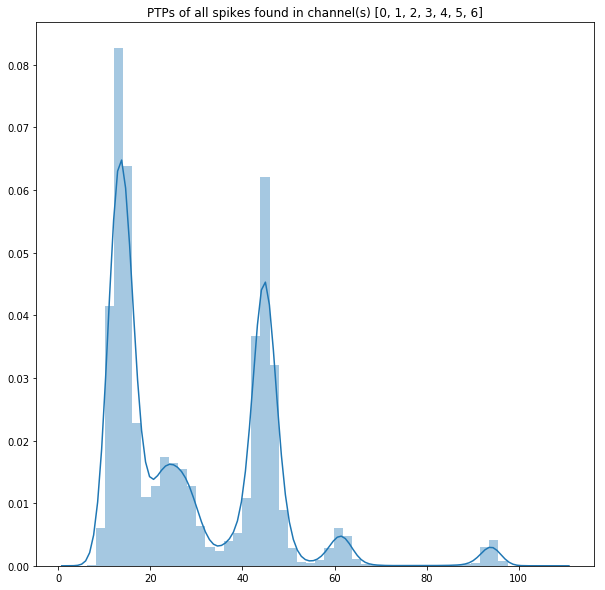

In [23]:
spikes_all_ptps = templates_utl.ptps(spikes_all)
sns.distplot(spikes_all_ptps)

_ = plt.title('PTPs of all spikes found in channel(s) {}'.format(CHANNELS))

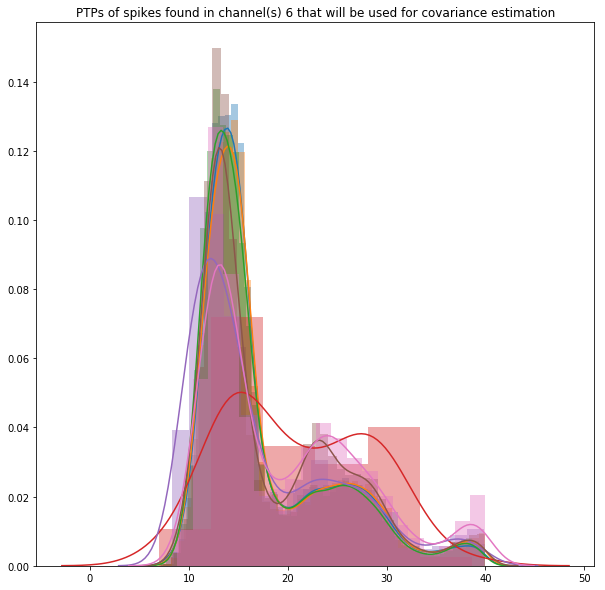

In [24]:
if isinstance(CHANNELS, list):
    if MAX_PTP_FOR_COVARIANCE_ESTIMATION:
        spikes = dict()
        for channel in CHANNELS:
            current_spikes = spikes_all_dict[channel]
            ptps = templates_utl.ptps(current_spikes)
            spikes[channel] = current_spikes[ptps < MAX_PTP_FOR_COVARIANCE_ESTIMATION]
    else:
        spikes = spikes_all_dict
    
    for ch, sp in spikes.items():
        sns.distplot(templates_utl.ptps(sp))    
        _ = plt.title('PTPs of spikes found in channel(s) {} that will be used for covariance estimation'.format(ch))
else:
    if MAX_PTP_FOR_COVARIANCE_ESTIMATION:
        spikes = spikes_all[spikes_all_ptps < MAX_PTP_FOR_COVARIANCE_ESTIMATION]
    else:
        spikes = spikes_all

    sns.distplot(templates_utl.ptps(spikes))    
    _ = plt.title('PTPs of spikes found in channel(s) {} that will be used for covariance estimation'.format(CHANNELS))

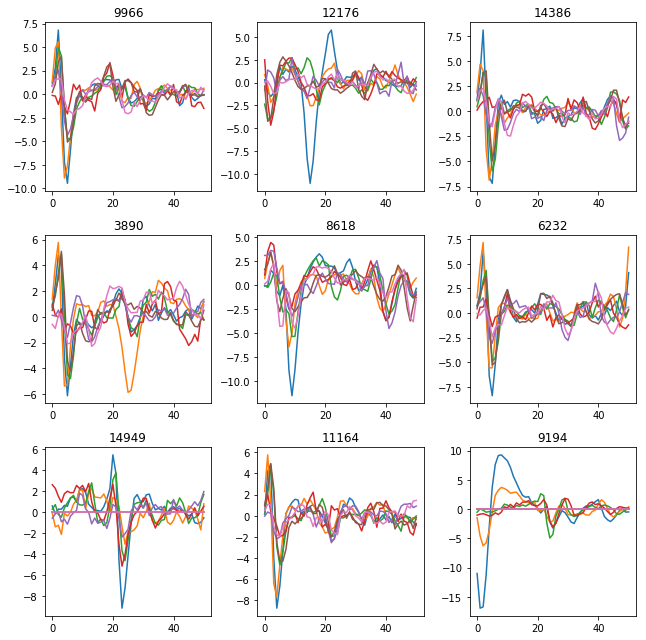

In [25]:
if isinstance(spikes, dict):
    plot.grid_from_array(spikes[CHANNELS[0]], axis=0, elements=9, auto_figsize=3)
else:
    plot.grid_from_array(spikes, axis=0, elements=9, auto_figsize=3)

## Compute the data sample covariance using the spikes snippets

In [26]:
if isinstance(spikes, dict):
    spikes_cov = {}
    
    for ch, sp in spikes.items():
        print('Computing covariance for channel {}'.format(ch))
        spikes_cov[ch] = (LedoitWolf(store_precision=False, assume_centered=True)
                               .fit(sp.reshape(sp.shape[0], -1))).covariance_
else:
    spikes_cov = (LedoitWolf(store_precision=False, assume_centered=True)
                    .fit(spikes.reshape(spikes.shape[0], -1))).covariance_

Computing covariance for channel 0
Computing covariance for channel 1
Computing covariance for channel 2
Computing covariance for channel 3
Computing covariance for channel 4
Computing covariance for channel 5
Computing covariance for channel 6


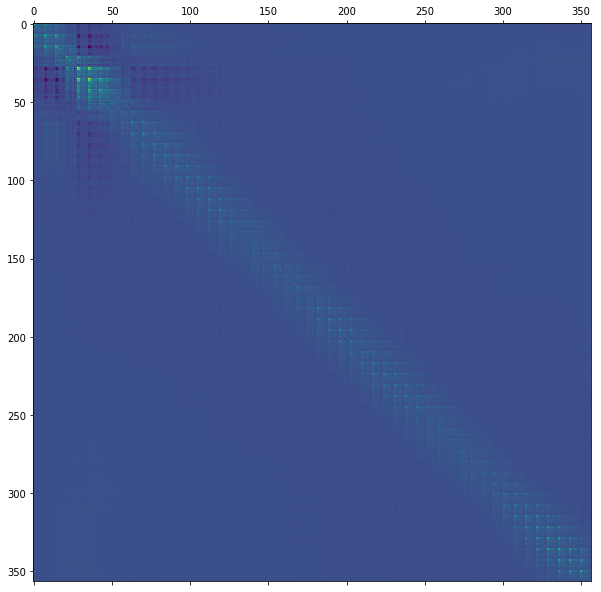

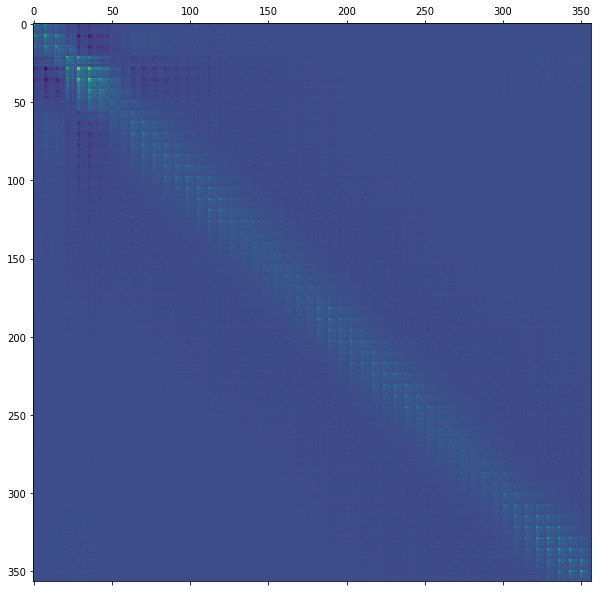

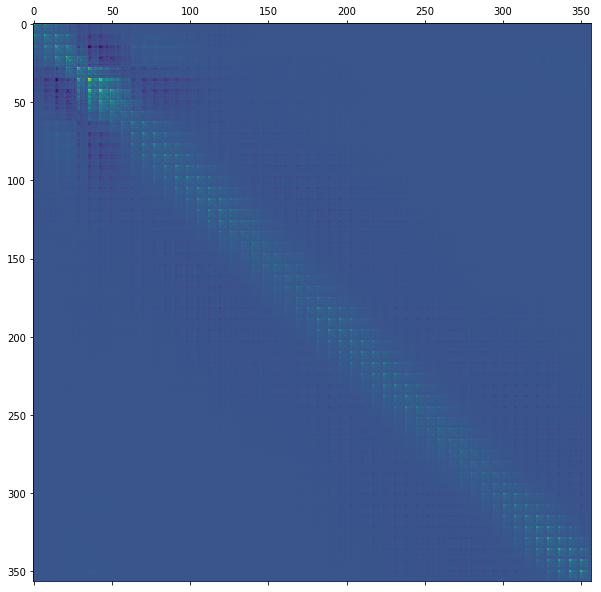

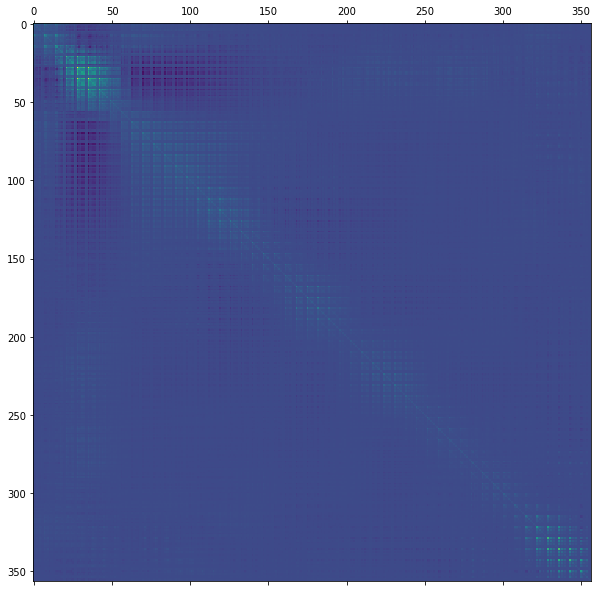

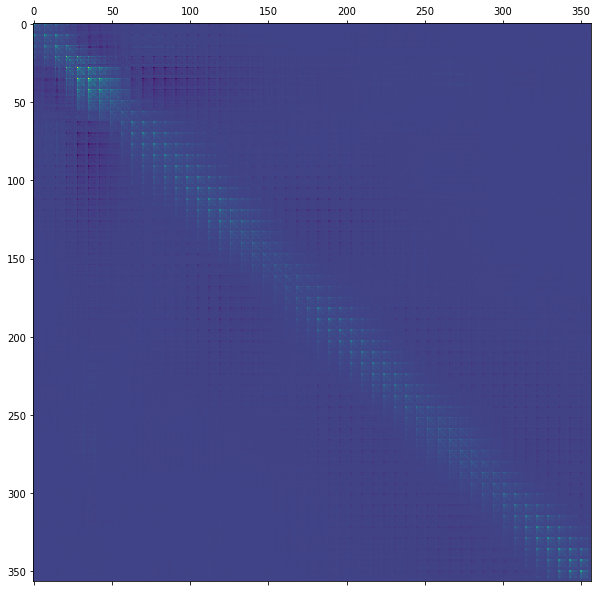

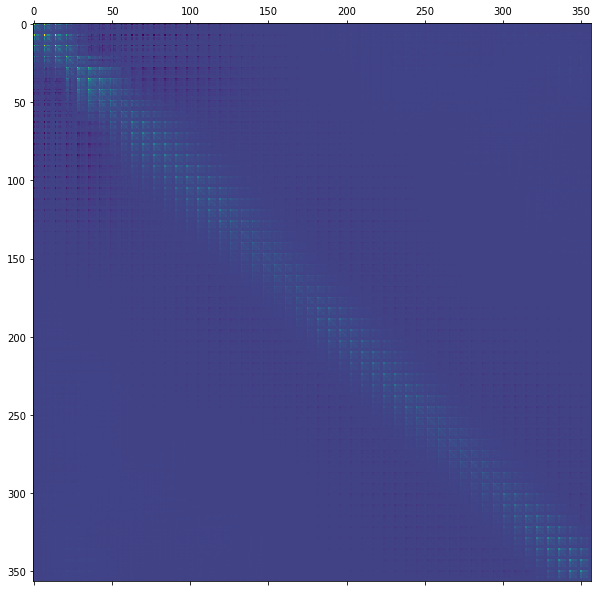

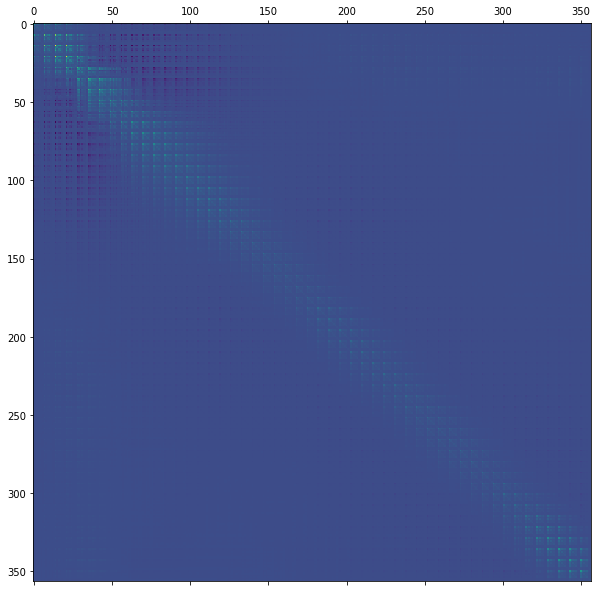

In [27]:
for _, cov in spikes_cov.items():
    plt.matshow(cov)

## Signal covariance estimation

$$\Sigma_{signal} = \Sigma_{data} - \Sigma_{noise}$$

In [28]:
cx = {ch: cov - noise_cov for ch, cov in spikes_cov.items()}

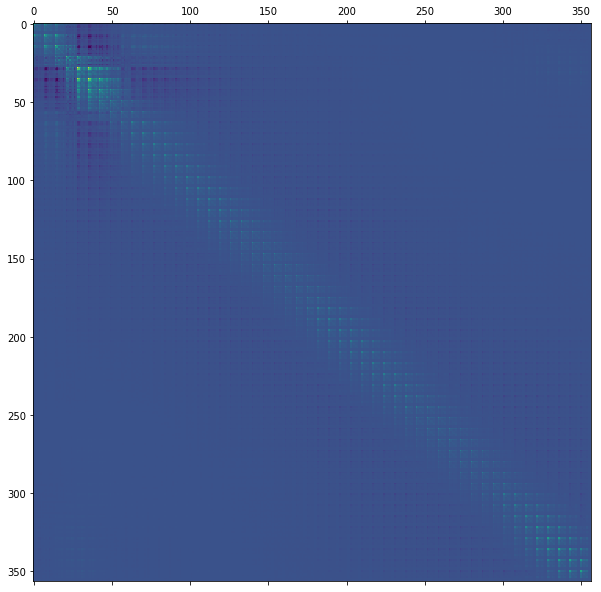

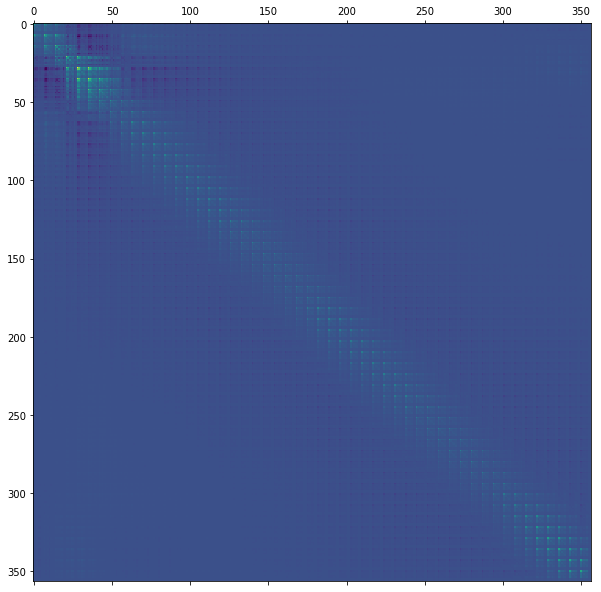

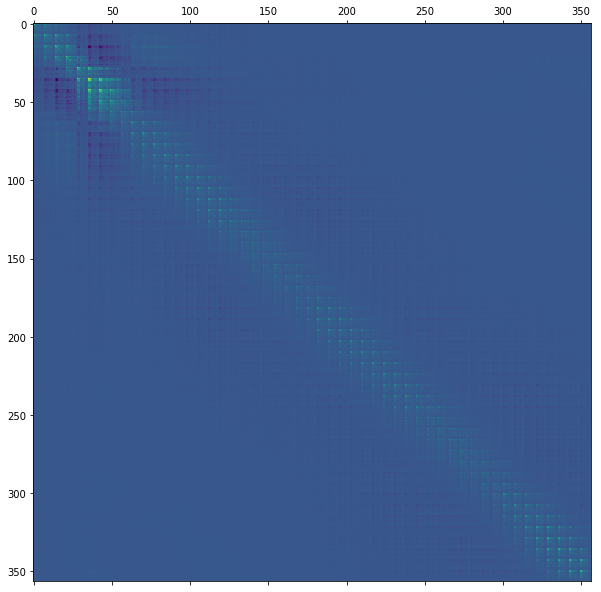

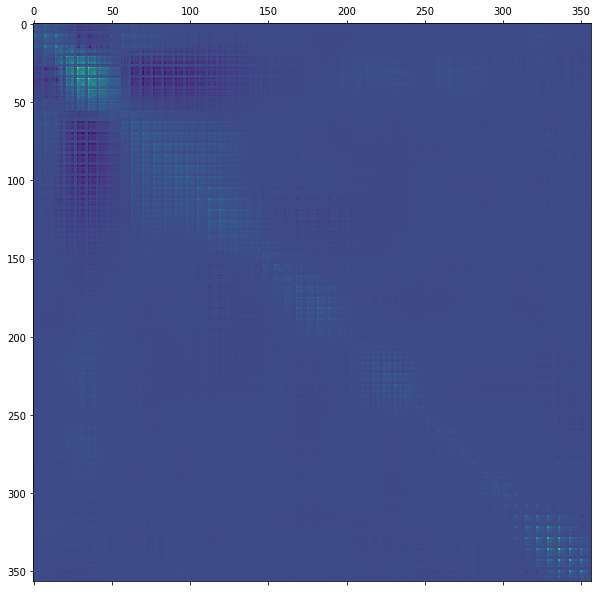

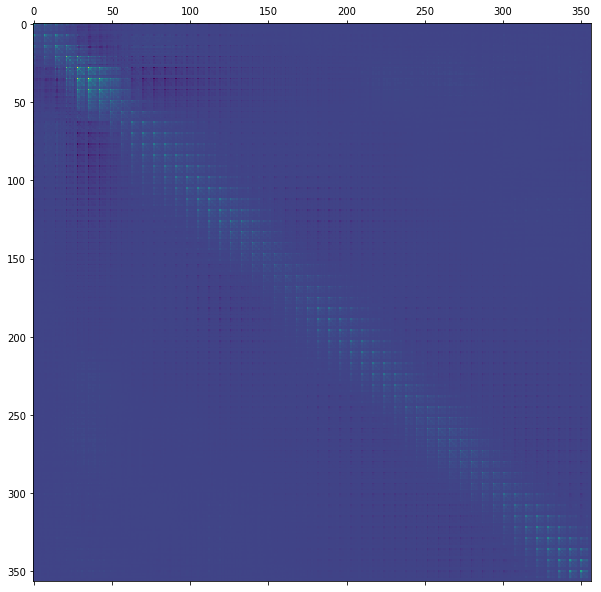

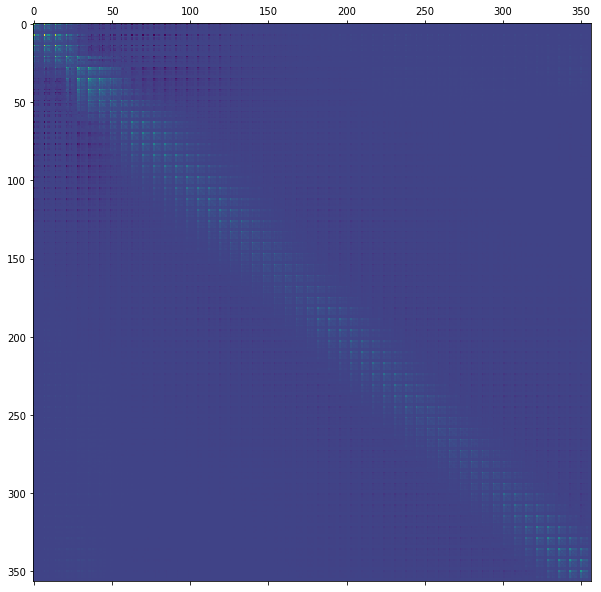

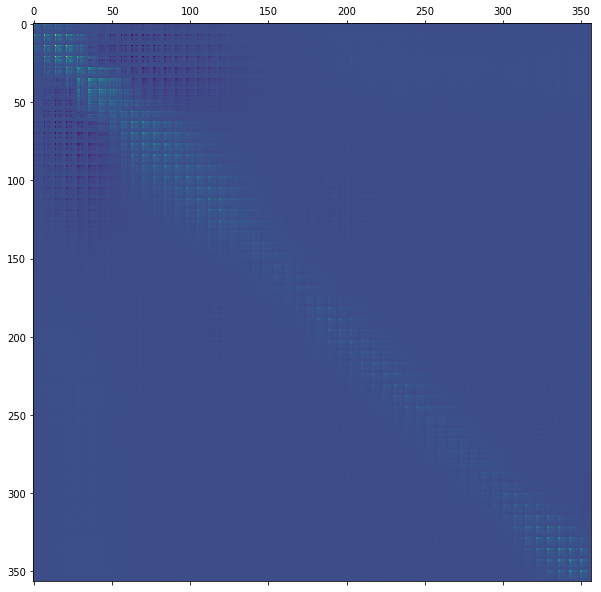

In [29]:
for _, cov_sig in cx.items():
    plt.matshow(cov_sig)


## Compute optimal mapping

$$M = \Sigma_{data}^{-1} * \Sigma_{signal}$$

In [30]:
def compute_mapping(spikes_cov, cx):
    mapping = np.matmul(np.linalg.inv(spikes_cov), cx)
    return mapping

mapping = {}

for ch in spikes_cov.keys():
    mapping[ch] = compute_mapping(spikes_cov[ch], cx[ch])

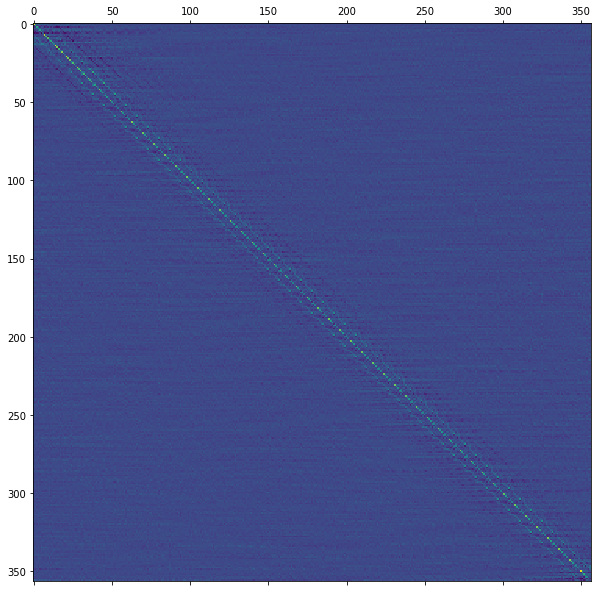

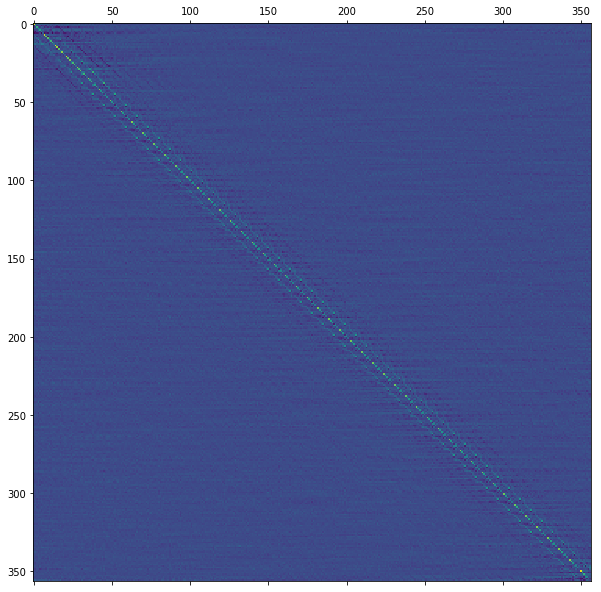

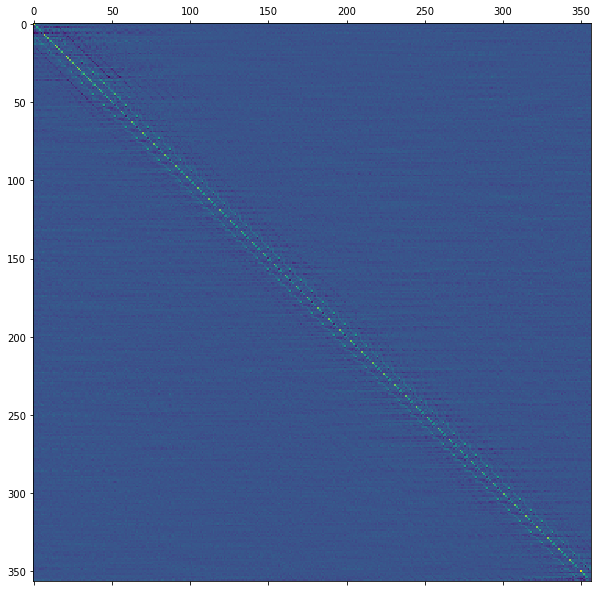

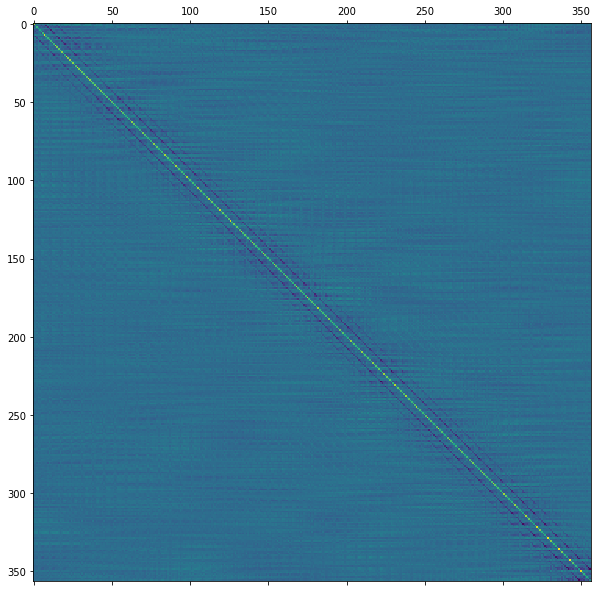

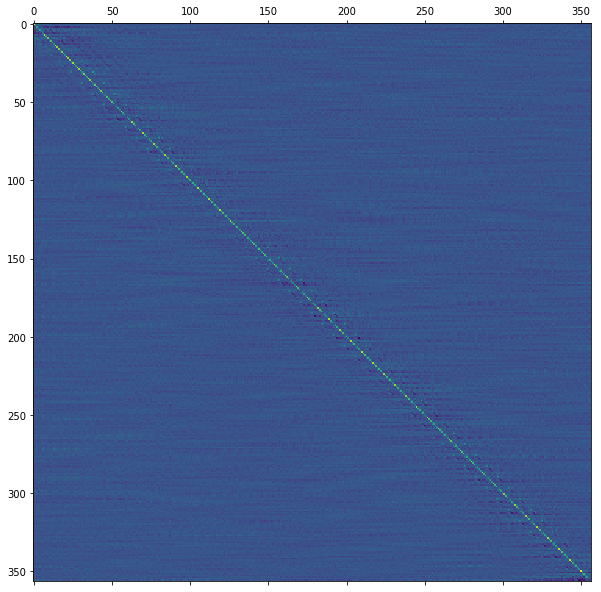

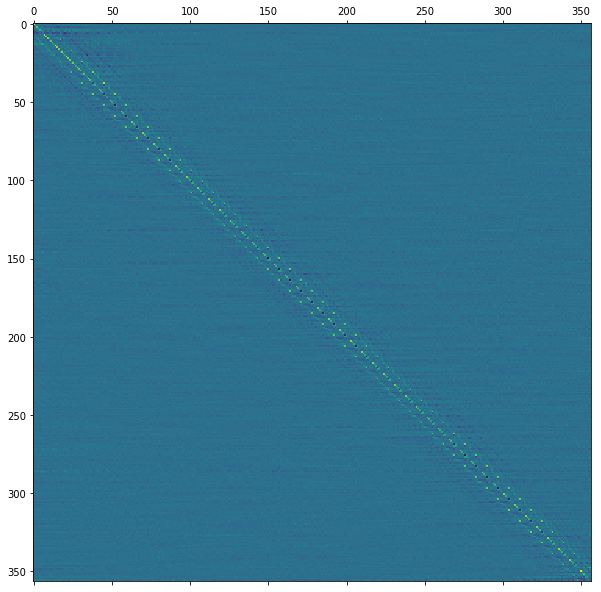

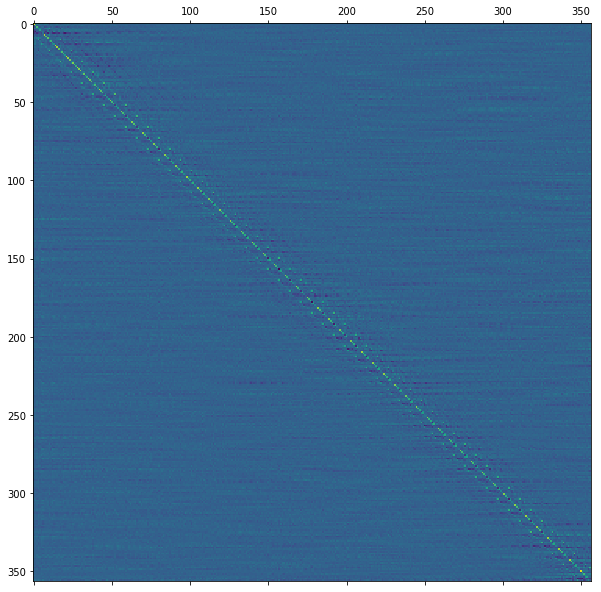

In [31]:
for _, a_mapping in mapping.items():
    plt.matshow(a_mapping)

In [32]:
from itertools import product

def make_toeplitz(m):
    """Takes the average of diagonals
    """
    n_diagonals = m.shape[0] - 1

    for i in range(n_diagonals):
        diag = m.diagonal(i)
        val = diag.mean()
        np.fill_diagonal(m[:, i:], val)

    for i in range(1, n_diagonals):
        diag = m.diagonal(-i)
        val = diag.mean()
        np.fill_diagonal(m[i:], val)


def slice_transformation(matrix, fn, offset=51):
    matrix = matrix.copy()
    
    n_windows = int(matrix.shape[0] / offset)

    slices = [slice(i * offset, (i+1) * offset)  for i in range(n_windows)]
    p = product(slices, slices)

    for i, j in p:
        m = matrix[i, j]
        make_toeplitz(m)
    
    return matrix

## Enforce Toeplitz

Make the optimal mapping a toeplitz matrix, by going through every 51 x 51 (waveform length) non-overlapping window and taking the mean accross diagonals.

In [33]:
mapping_toeplitz = {}

for channel, a_mapping in mapping.items():
    mapping_toeplitz[channel] = slice_transformation(a_mapping, make_toeplitz)

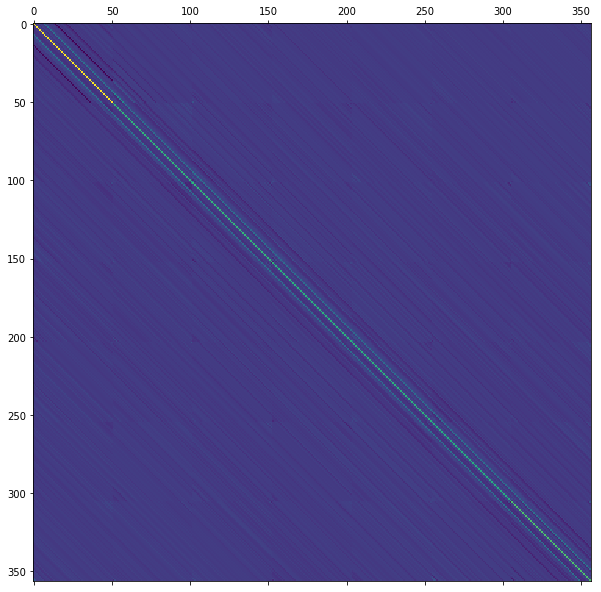

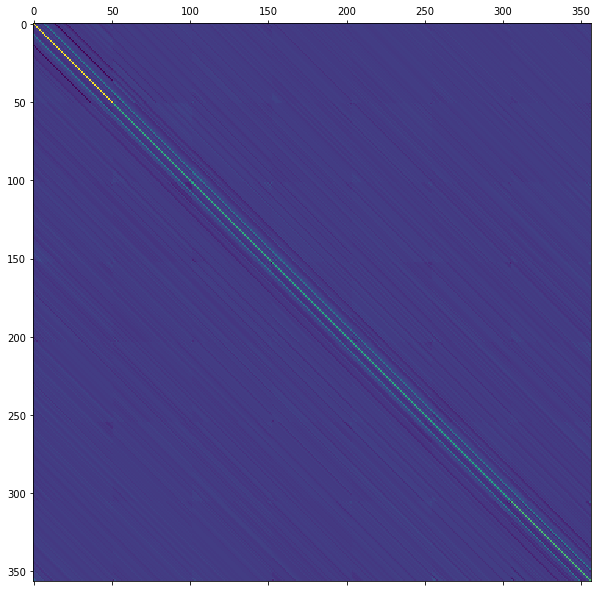

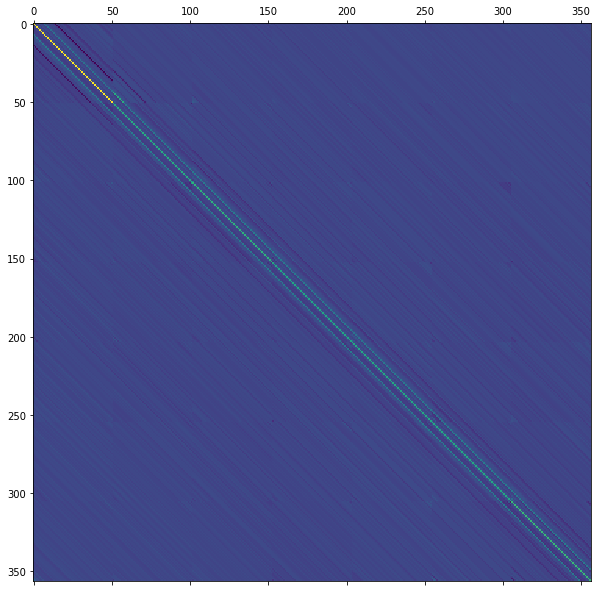

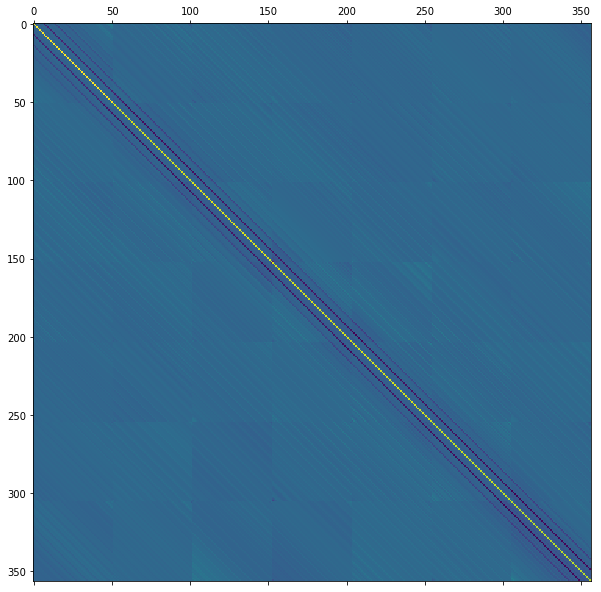

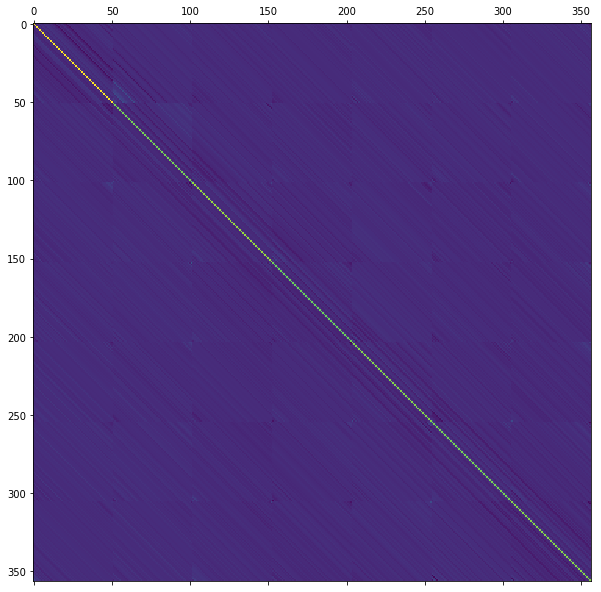

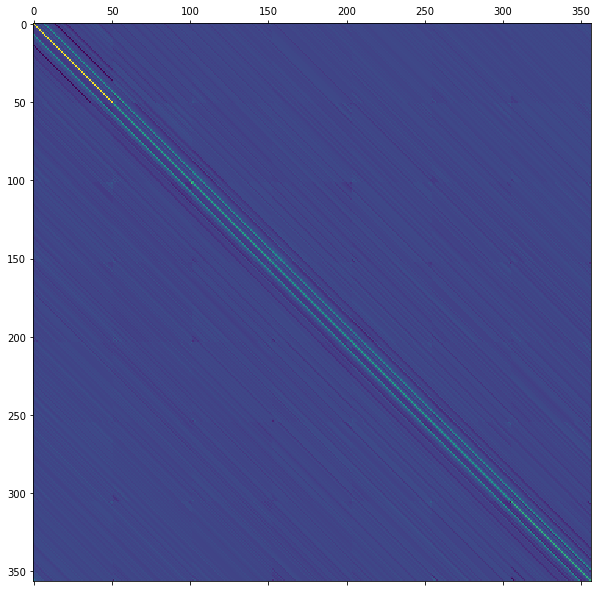

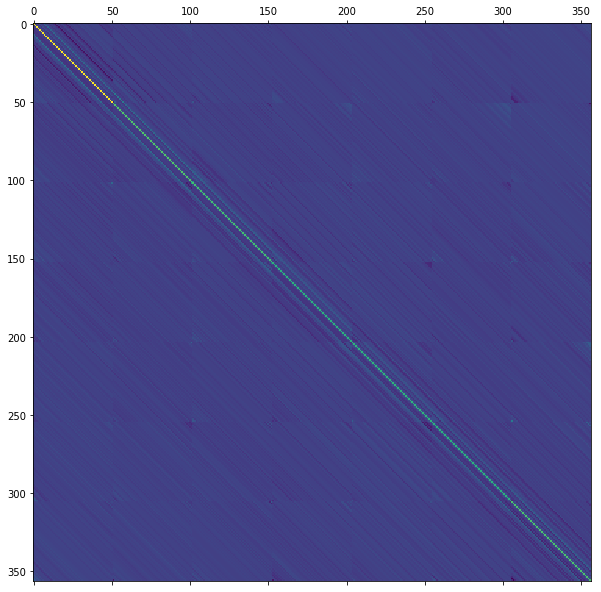

In [34]:
for a_mapping in mapping_toeplitz.values():
    plt.matshow(a_mapping)

In [35]:
# decide whether to use the toeplitz mapping or not
if USE_TOEPLITZ:
    denoiser = mapping_toeplitz
else:
    denoiser = mapping

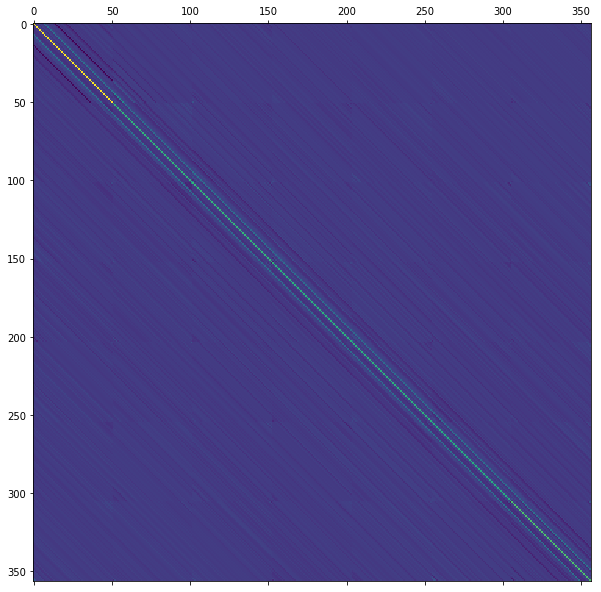

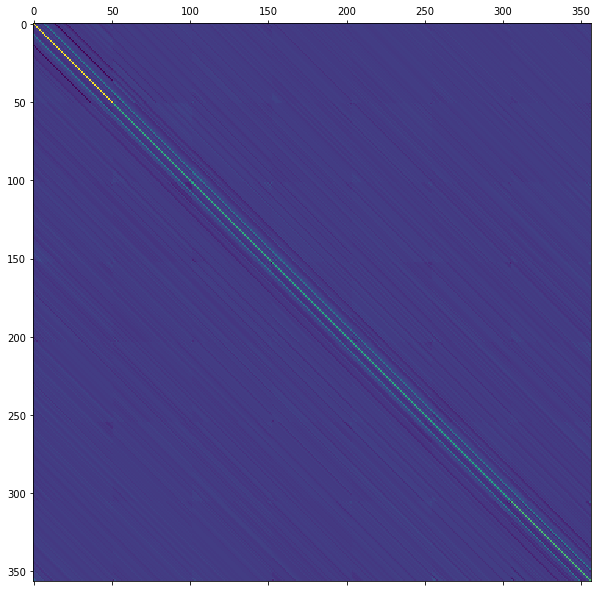

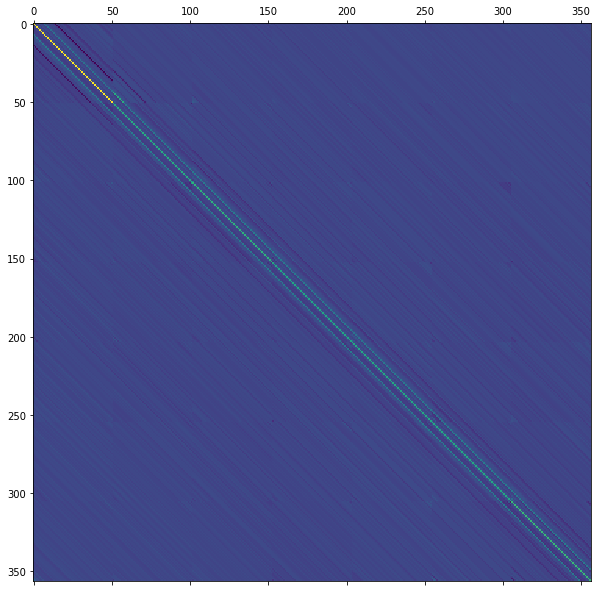

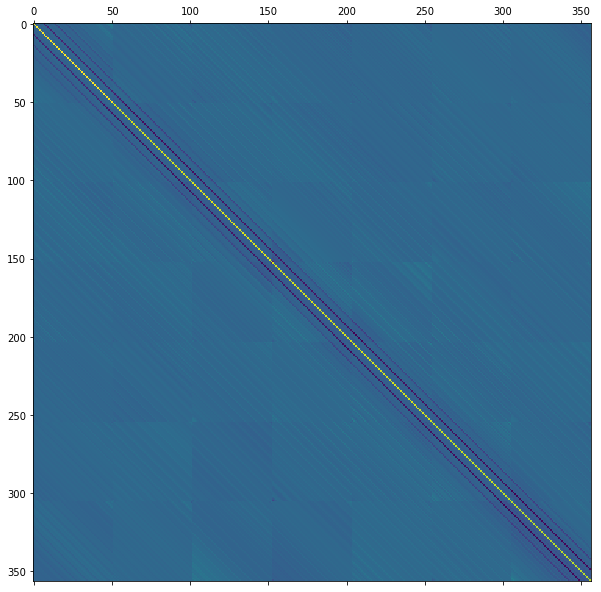

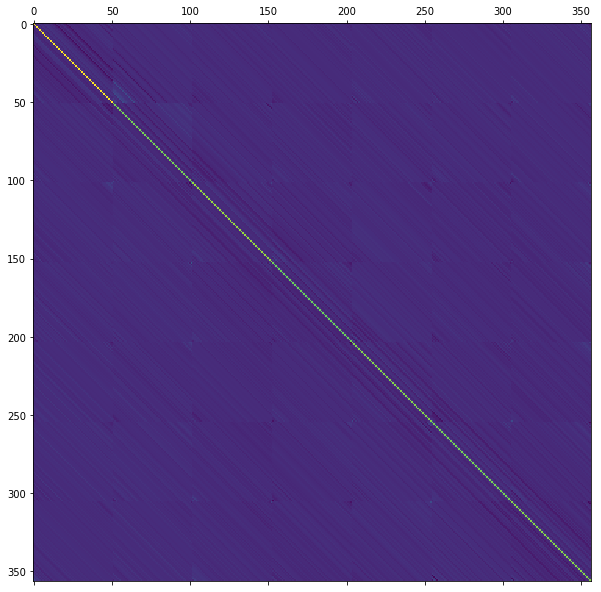

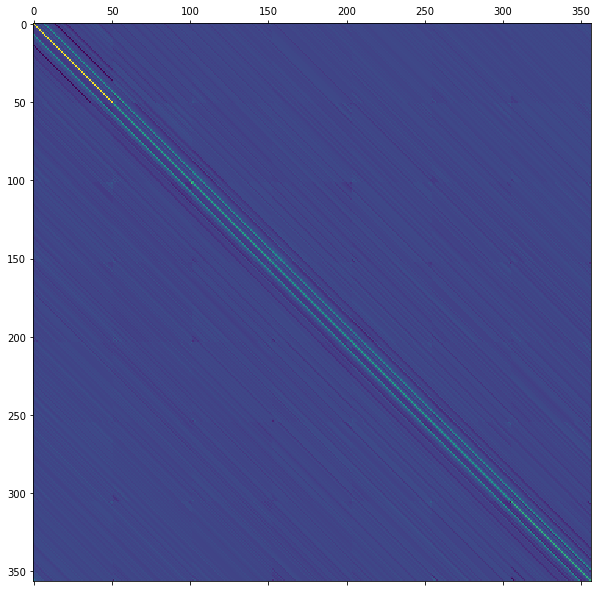

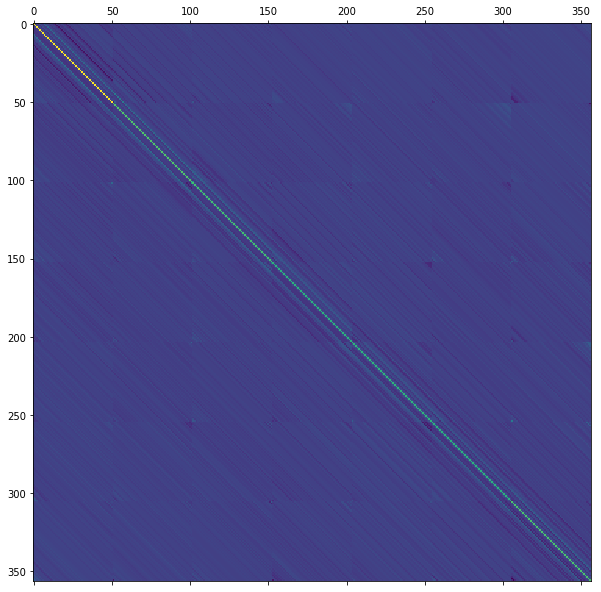

In [36]:
for ch, den in denoiser.items():
    plt.matshow(den)

In [37]:
denoised = {}

for ch, sp in spikes.items():
    denoised[ch] = np.matmul(sp.reshape(sp.shape[0], -1), denoiser[ch]).reshape(-1, 51, 7)

In [38]:
for ch, d in denoised.items():
    idxs = np.argsort(templates_utl.ptps(d))

    denoised[ch] = d[idxs]
    spikes[ch] = spikes[ch][idxs]

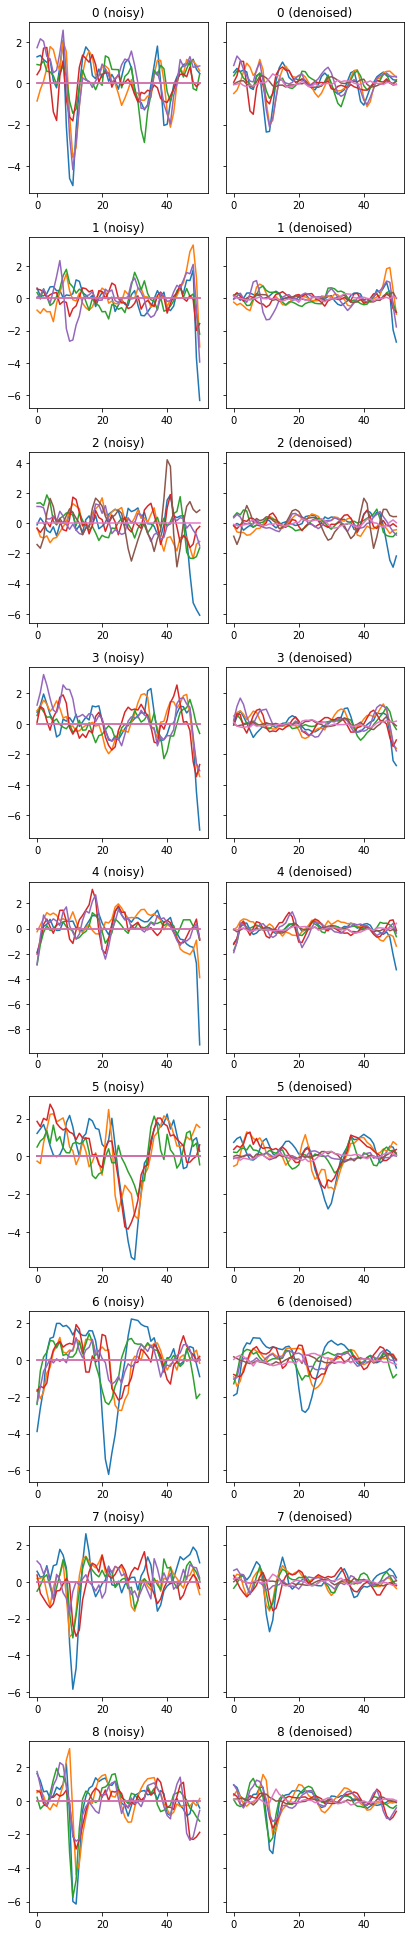

In [39]:
a_channel = CHANNELS[0]

plot.grid_from_array([spikes[a_channel], denoised[a_channel]], axis=0, elements=range(9),
                     auto_figsize=3, sharey='row', group_names=['noisy', 'denoised'])

## Denoise recordings chunkwise

In [40]:
def create_chunks(recordings, n_chunks, window_size, offset):
    chunks_all = []
    
    n_observations, n_channels = recordings.shape

    for i in range(n_chunks):
        start = i * offset
        end = i * offset + window_size
        
        if end > n_observations:
            end = n_observations

            if end - start == window_size:
                chunk = recordings[start:end, :]
                chunks_all.append(chunk)

            break
        else:
            chunk = recordings[start:end, :]
            chunks_all.append(chunk)
    
    return np.stack(chunks_all)

def denoise_chunks(chunks, mapping):
    denoised = np.matmul(chunks.reshape(chunks.shape[0], -1), mapping).reshape(-1, 51, 7)
    return denoised

def unroll_chunks(chunks):
    return chunks.reshape(-1, 7)

In [41]:
n_chunks = 200000
max_idx = n_chunks * 51

denoised_rec = dict()

for channel in CHANNELS:
    print(f'denoising channel {channel}')
    chunks = create_chunks(rec_all[:, ch_idx[channel]], n_chunks, 51, 51)
    denoised = denoise_chunks(chunks, denoiser[channel])
    denoised_rec[channel] = unroll_chunks(denoised)

denoising channel 0
denoising channel 1
denoising channel 2
denoising channel 3
denoising channel 4
denoising channel 5
denoising channel 6


In [42]:
from yass.preprocess.batch import standarize

for ch in CHANNELS:
    stds = standarize._standard_deviation(denoised_rec[ch], CONFIG.recordings.sampling_rate)
    denoised_rec[ch] = np.divide(denoised_rec[ch], stds)

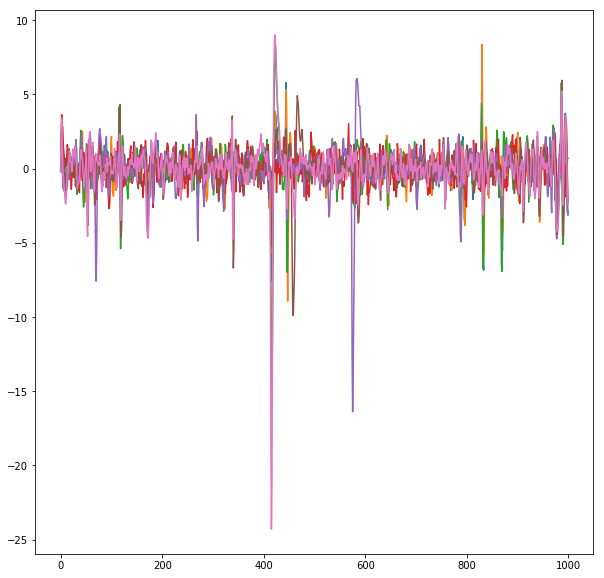

In [43]:
_ = plt.plot(rec[:1000, :])

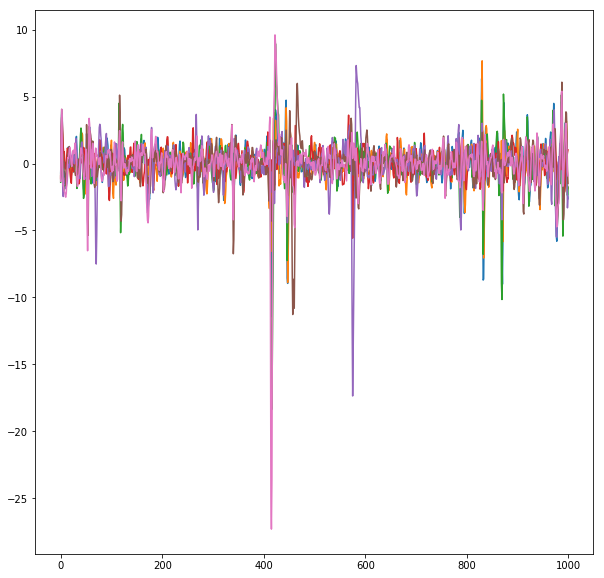

In [44]:
_ = plt.plot(denoised_rec[CHANNELS[0]][:1000, :])

## Compare distribution

In [45]:
def detect_on_denoised_data(denoised_rec, ch):
    # dump denoised data
    standarized_path_denoised = f'/tmp/denoised-{ch}.bin'
    denoised_rec.tofile(standarized_path_denoised)
    standarized_params_denoised = {'data_order': 'samples', 'dtype': 'float64', 'n_channels': 7}
    yass.set_config("../config/gcloud/49/default.yaml", 'denoised')
    CONFIG = read_config()
    
#     rec_denoised = RecordingsReader(standarized_path_denoised, standarized_params_denoised['dtype'],
#                             standarized_params_denoised['n_channels'],
#                             standarized_params_denoised['data_order'],
#                             loader='array')
#     rec_denoised.shape

    (_,#standarized_path,
     _,#standarized_params,
     whiten_filter) = (preprocess
                       .run(if_file_exists='skip'))

    (index_clean_denoised_arr,
     index_all_denoised_arr) = nnet.run(standarized_path_denoised, standarized_params_denoised, whiten_filter,
                                      'overwrite', False,
                                       path_to_detector,
                                       autoencoder='/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/ae_nn2.ckpt')
    
    return index_clean_denoised_arr, index_all_denoised_arr


from collections import namedtuple
IndexTuple = namedtuple('IndexTuple', ['clean', 'all'])

indexes = {}

for ch, denoised in denoised_rec.items():
    print(f'Detecting on denoised data from channel {ch}...')
    clean, all_ = detect_on_denoised_data(denoised, ch)
    clean = SpikeIndex(clean)
    all_ = SpikeIndex(all_)

    # just get spikes for main channel in denoised data
    clean = clean.get_times_from_channel(ch)
    all_ = all_.get_times_from_channel(ch)

    indexes[ch] = IndexTuple(clean=clean, all=all_)

Detecting on denoised data from channel 0...


100%|██████████| 657/657 [00:14<00:00, 46.77it/s]
/home/Edu/yass/src/yass/neuralnetwork/model.py:110: UserWarning: Input waveform length (51) is larger than Network's (31) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only (31) middle observations for predition
  self.waveform_length))
/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


Detecting on denoised data from channel 1...


100%|██████████| 657/657 [00:13<00:00, 49.33it/s]
/home/Edu/yass/src/yass/neuralnetwork/model.py:110: UserWarning: Input waveform length (51) is larger than Network's (31) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only (31) middle observations for predition
  self.waveform_length))
/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


Detecting on denoised data from channel 2...


100%|██████████| 657/657 [00:15<00:00, 43.41it/s]
/home/Edu/yass/src/yass/neuralnetwork/model.py:110: UserWarning: Input waveform length (51) is larger than Network's (31) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only (31) middle observations for predition
  self.waveform_length))
/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


Detecting on denoised data from channel 3...


100%|██████████| 657/657 [00:10<00:00, 59.74it/s]
/home/Edu/yass/src/yass/neuralnetwork/model.py:110: UserWarning: Input waveform length (51) is larger than Network's (31) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only (31) middle observations for predition
  self.waveform_length))
/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


Detecting on denoised data from channel 4...


100%|██████████| 657/657 [00:14<00:00, 46.16it/s]
/home/Edu/yass/src/yass/neuralnetwork/model.py:110: UserWarning: Input waveform length (51) is larger than Network's (31) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only (31) middle observations for predition
  self.waveform_length))
/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


Detecting on denoised data from channel 5...


100%|██████████| 657/657 [00:16<00:00, 40.17it/s]
/home/Edu/yass/src/yass/neuralnetwork/model.py:110: UserWarning: Input waveform length (51) is larger than Network's (31) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only (31) middle observations for predition
  self.waveform_length))
/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


Detecting on denoised data from channel 6...


100%|██████████| 657/657 [00:14<00:00, 43.86it/s]
/home/Edu/yass/src/yass/neuralnetwork/model.py:110: UserWarning: Input waveform length (51) is larger than Network's (31) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only (31) middle observations for predition
  self.waveform_length))
/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


In [46]:
indexes_raw = {}

for ch in CHANNELS:
    clean = index_clean.get_times_from_channel(ch)
    all_ = index_all.get_times_from_channel(ch)
    indexes_raw[ch] = IndexTuple(clean=clean, all=all_)

for ch, index in indexes.items():
    print(f'{ch}: {index.clean.shape}, {index.all.shape}')
    print(indexes_raw[ch].clean.shape, indexes_raw[ch].all.shape)

0: (4334,), (31475,)
(1650,) (17721,)
1: (35429,), (108586,)
(3756,) (29250,)
2: (13226,), (93481,)
(948,) (18673,)
3: (16402,), (72530,)
(3,) (107,)
4: (19736,), (96844,)
(464,) (2132,)
5: (22479,), (104444,)
(2002,) (28060,)
6: (19597,), (49273,)
(86,) (12577,)


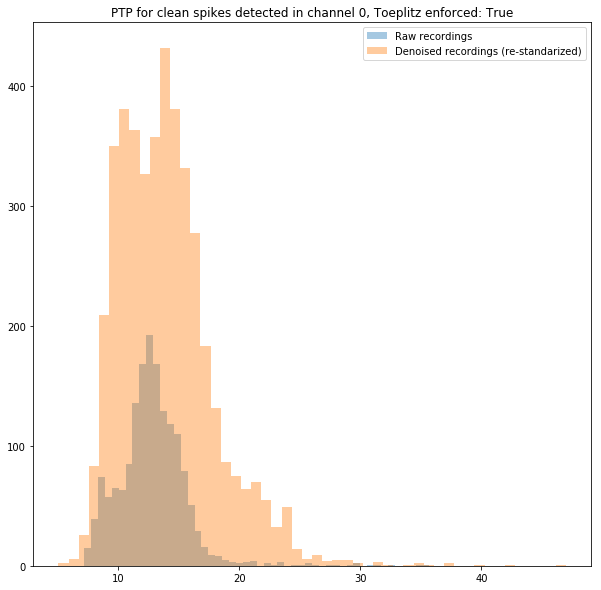

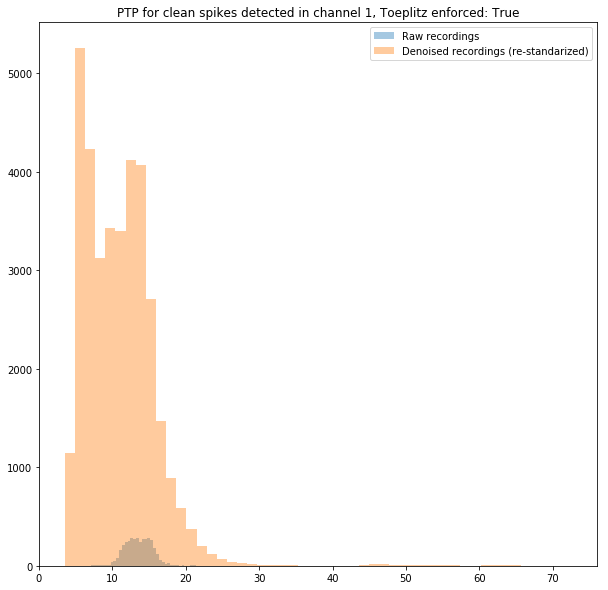

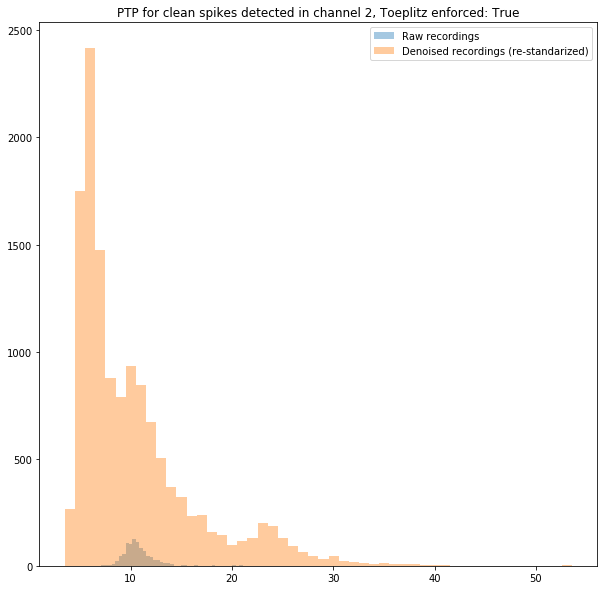

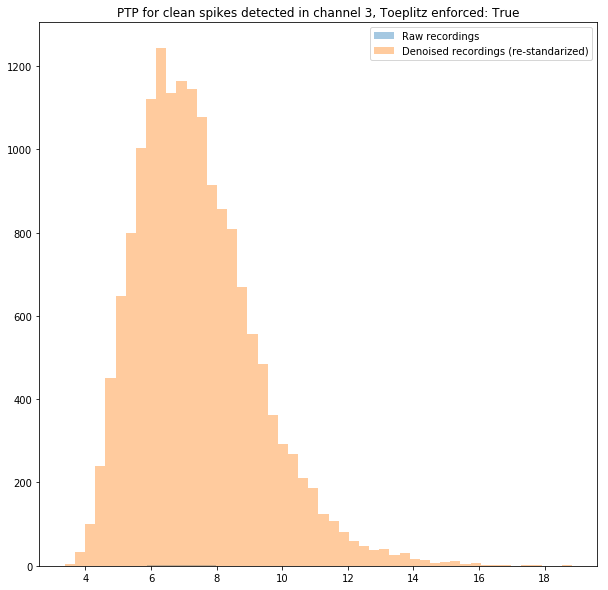

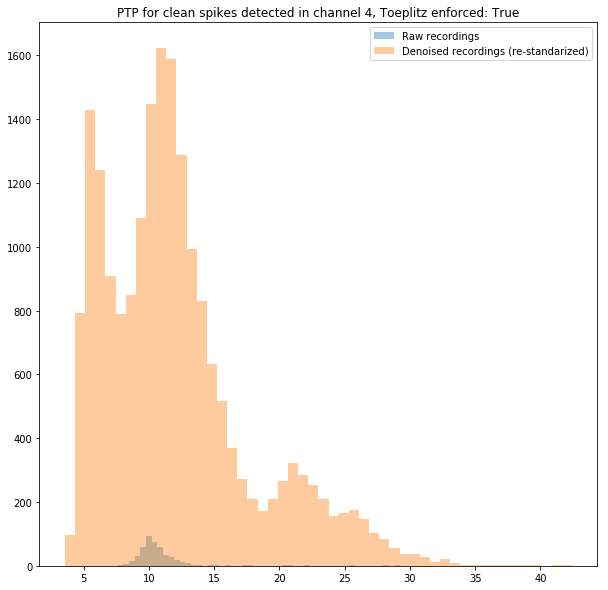

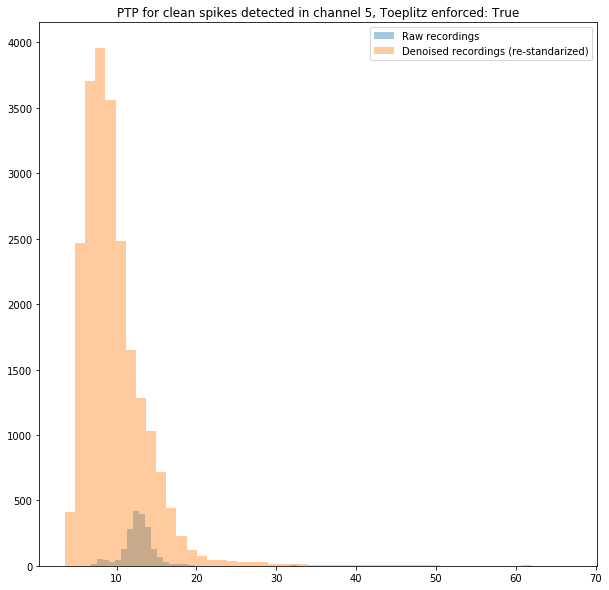

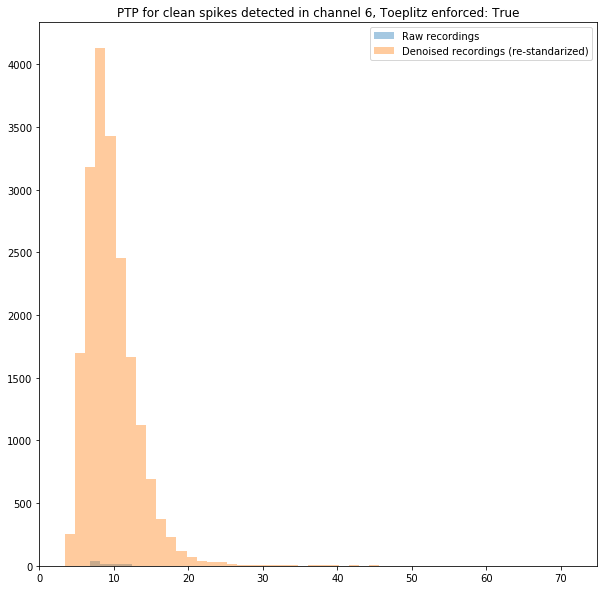

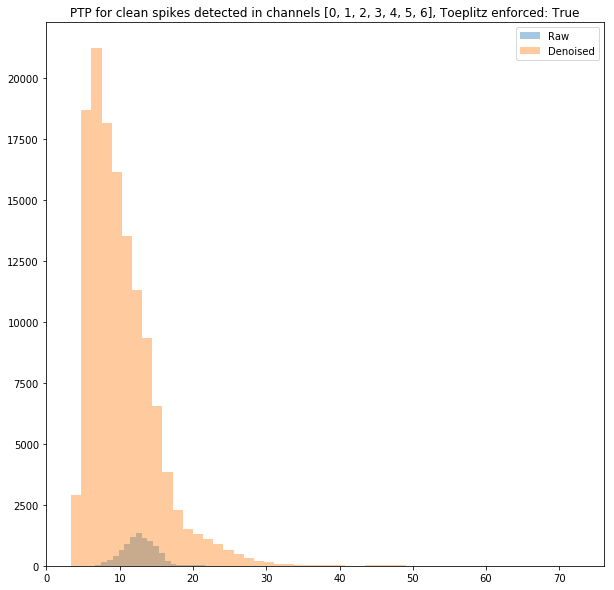

In [47]:
def plot_ptps(rec, spikes, ax=None, waveform_length=51, label=None, norm_hist=False, kde=False):
    wfs = read_waveforms(rec, spikes, waveform_length=51)
    ptps = templates_utl.ptps(wfs)
    sns.distplot(ptps, ax=ax, label=label, norm_hist=norm_hist, kde=norm_hist)

    return ptps

ptps_raw = []
ptps_denoised = []

for ch in CHANNELS:
    plt.figure()

    rec = rec_all[:, ch_idx[ch]]
    
    standarized_path_denoised = f'/tmp/denoised-{ch}.bin'
    standarized_params_denoised = {'data_order': 'samples', 'dtype': 'float64', 'n_channels': 7}
    rec_denoised = RecordingsReader(standarized_path_denoised, standarized_params_denoised['dtype'],
                                    standarized_params_denoised['n_channels'],
                                    standarized_params_denoised['data_order'],
                                    loader='array')

    raw = plot_ptps(rec, indexes_raw[ch].clean, label='Raw recordings')
    # plot_ptps(rec, index_clean_denoised, label='Raw recordings, denoised spike index')
    denoised = plot_ptps(rec_denoised, indexes[ch].clean, label='Denoised recordings (re-standarized)')
    
    ptps_raw.append(raw)
    ptps_denoised.append(denoised)

    plt.legend()
    _ = plt.title('PTP for clean spikes detected in channel {}, Toeplitz enforced: {}'.format(ch, USE_TOEPLITZ))


ptps_raw = np.concatenate(ptps_raw, axis=0)
ptps_denoised = np.concatenate(ptps_denoised, axis=0)

plt.figure()
sns.distplot(ptps_raw, label='Raw', norm_hist=False, kde=False)
sns.distplot(ptps_denoised, label='Denoised', norm_hist=False, kde=False)
plt.legend()
_ = plt.title('PTP for clean spikes detected in channels {}, Toeplitz enforced: {}'.format(CHANNELS, USE_TOEPLITZ))

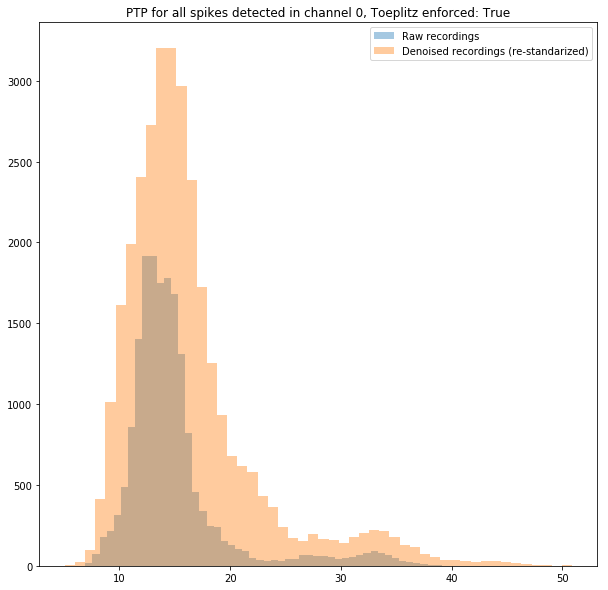

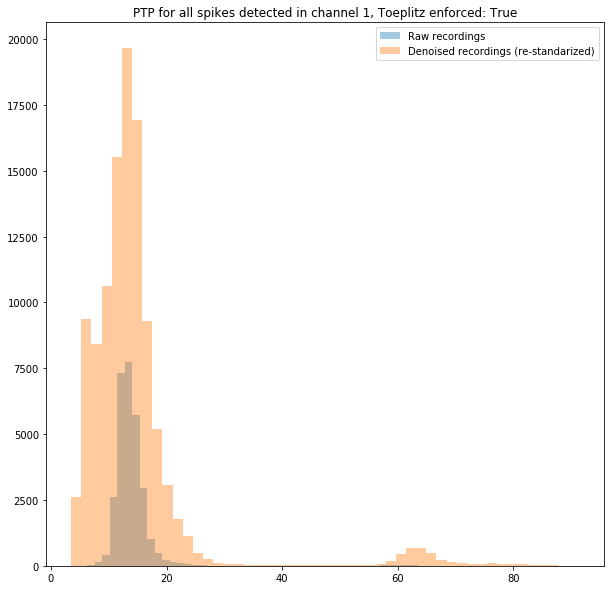

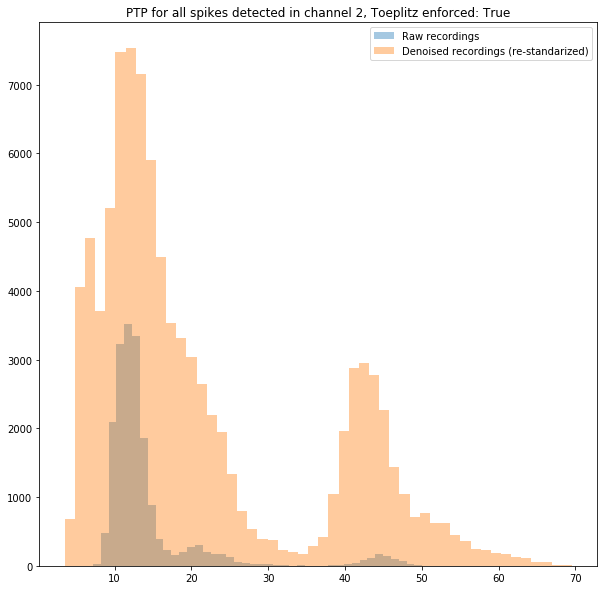

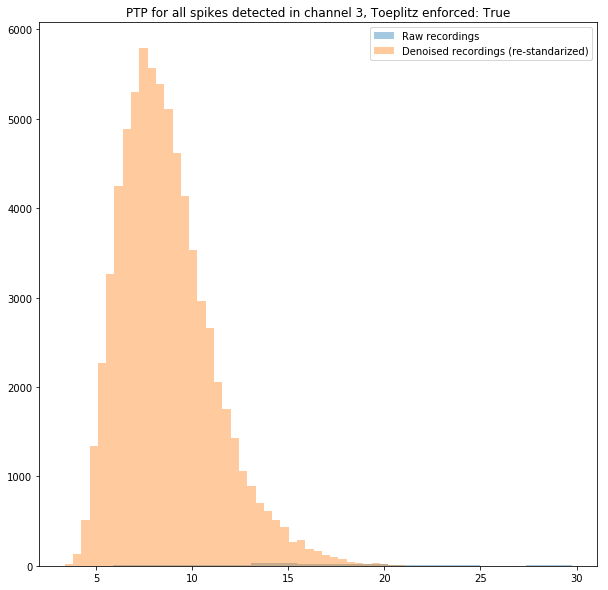

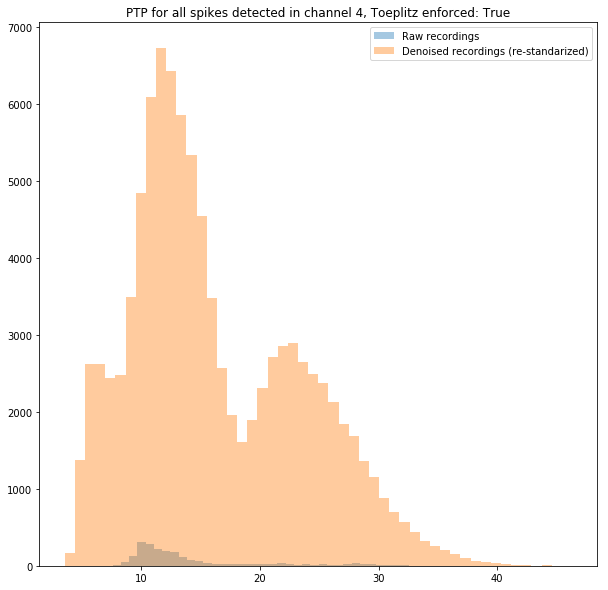

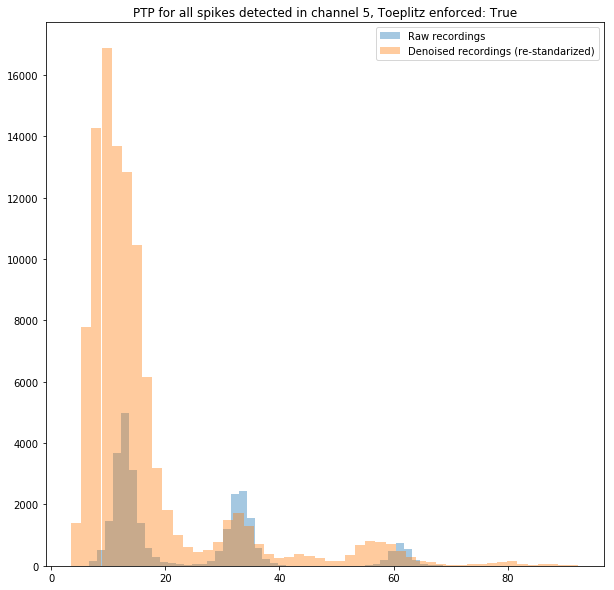

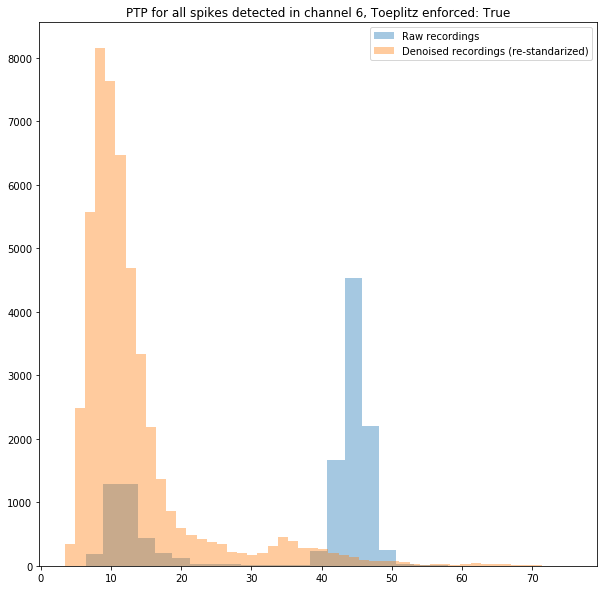

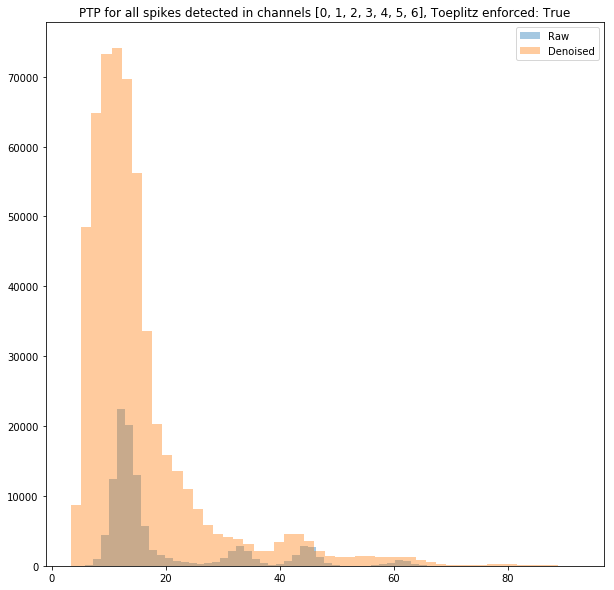

In [48]:
ptps_raw = []
ptps_denoised = []

for ch in CHANNELS:
    plt.figure()

    rec = rec_all[:, ch_idx[ch]]
    
    standarized_path_denoised = f'/tmp/denoised-{ch}.bin'
    standarized_params_denoised = {'data_order': 'samples', 'dtype': 'float64', 'n_channels': 7}
    rec_denoised = RecordingsReader(standarized_path_denoised, standarized_params_denoised['dtype'],
                                    standarized_params_denoised['n_channels'],
                                    standarized_params_denoised['data_order'],
                                    loader='array')

    # plot_ptps(rec, index_clean_denoised, label='Raw recordings, denoised spike index')
    raw = plot_ptps(rec, indexes_raw[ch].all, label='Raw recordings')
    denoised = plot_ptps(rec_denoised, indexes[ch].all, label='Denoised recordings (re-standarized)')
    
    ptps_raw.append(raw)
    ptps_denoised.append(denoised)

    plt.legend()
    _ = plt.title('PTP for all spikes detected in channel {}, Toeplitz enforced: {}'.format(ch, USE_TOEPLITZ))

    
ptps_raw = np.concatenate(ptps_raw, axis=0)
ptps_denoised = np.concatenate(ptps_denoised, axis=0)

plt.figure()
sns.distplot(ptps_raw, label='Raw', norm_hist=False, kde=False)
sns.distplot(ptps_denoised, label='Denoised', norm_hist=False, kde=False)
plt.legend()
_ = plt.title('PTP for all spikes detected in channels {}, Toeplitz enforced: {}'.format(CHANNELS, USE_TOEPLITZ))

In [49]:
new = set(indexes[0].all) - set(indexes_raw[0].all)
missing = set(indexes_raw[0].all) - set(indexes[0].all)

In [ ]:
# test on noise

In [ ]:
# test on templates

In [67]:
# read waveforms from denoised and raw recordings
def load_denoised(ch):
    standarized_path_denoised = f'/tmp/denoised-{ch}.bin'
    standarized_params_denoised = {'data_order': 'samples', 'dtype': 'float64', 'n_channels': 7}
        
    rec_denoised = RecordingsReader(standarized_path_denoised, standarized_params_denoised['dtype'],
                            standarized_params_denoised['n_channels'],
                            standarized_params_denoised['data_order'],
                            loader='array')
    return rec_denoised

if SAVE_RESULTS:
    wfs = []

    for ch in CHANNELS:
        idx = indexes[ch].clean
        rec = load_denoised(ch)
        w = read_waveforms(rec, idx, waveform_length=51)
        wfs.append(w)

    wfs = np.concatenate(wfs, axis=0)
    
    np.save('/tmp/wfs-clean-denoised.npy', wfs)
    
    wfs = []
    
    for ch in CHANNELS:
        idx = indexes_raw[ch].clean
        rec = rec_all[:, ch_idx[ch]]
        w = read_waveforms(rec, idx, waveform_length=51)
        wfs.append(w)

    wfs = np.concatenate(wfs, axis=0)
    
    np.save('/tmp/wfs-clean-raw.npy', wfs)

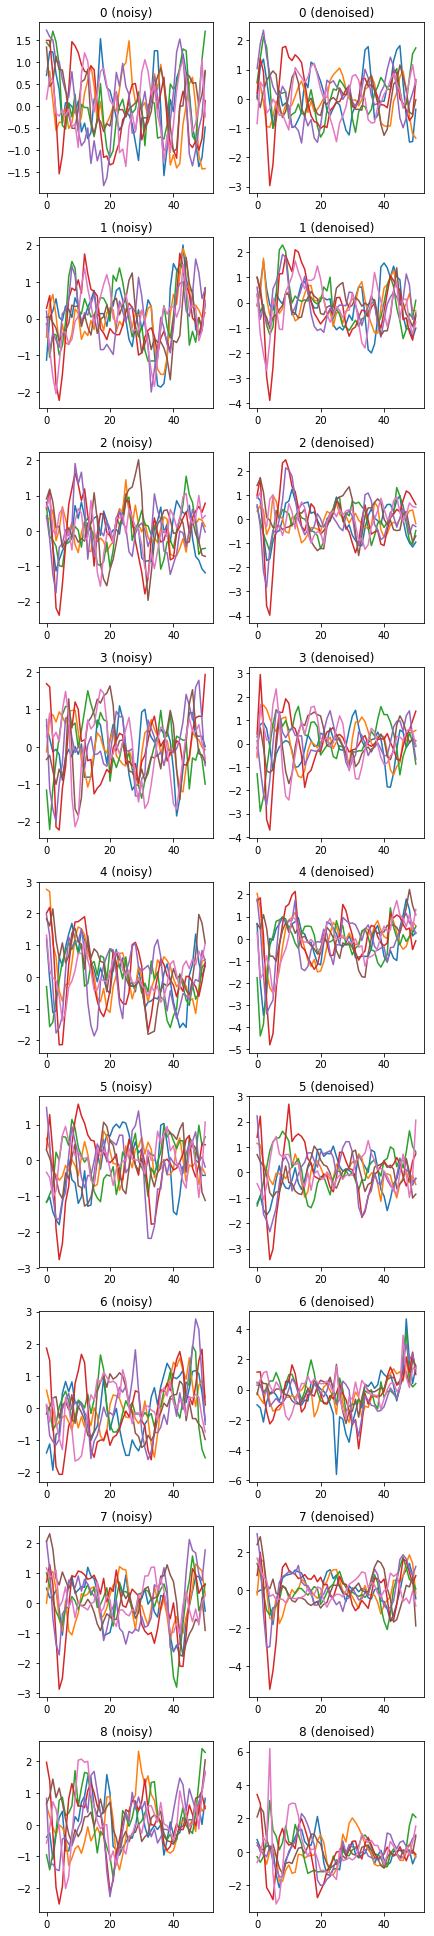

In [50]:
new_wfs_noisy = read_waveforms(rec, new, waveform_length=51)
new_wfs_denoised = read_waveforms(rec_denoised, new, waveform_length=51)

idxs = np.argsort(templates_utl.ptps(new_wfs_noisy))
new_wfs_noisy = new_wfs_noisy[idxs]
new_wfs_denoised = new_wfs_denoised[idxs]

plot.grid_from_array([new_wfs_noisy, new_wfs_denoised], axis=0,
                     elements=range(9), auto_figsize=3,
                     group_names=['noisy', 'denoised'])

In [51]:
detector.predict(new_wfs_noisy).sum(), detector.predict(new_wfs_denoised).sum()

(940, 2147)

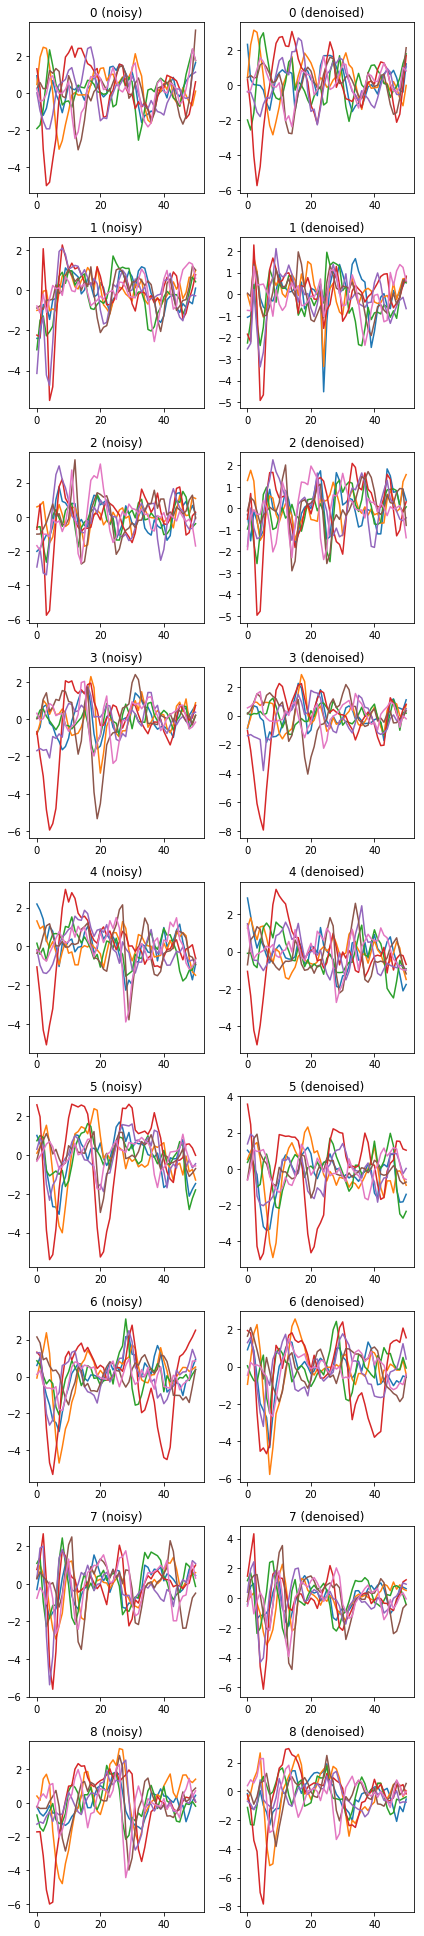

In [52]:
missing_wfs_noisy = read_waveforms(rec, missing, waveform_length=51)
missing_wfs_denoised = read_waveforms(rec_denoised, missing, waveform_length=51)

idxs = np.argsort(templates_utl.ptps(missing_wfs_noisy))

missing_wfs_noisy = missing_wfs_noisy[idxs]
missing_wfs_denoised = missing_wfs_denoised[idxs]

plot.grid_from_array([missing_wfs_noisy, missing_wfs_denoised], axis=0,
                     elements=range(9), auto_figsize=3,
                     group_names=['noisy', 'denoised'])

In [53]:
detector.predict(missing_wfs_noisy).sum(), detector.predict(missing_wfs_denoised).sum()

(86, 106)